<center> <b> <font size = 10, face="Droid Sans">  Cognition and Computation - Project </font> </b> </center> 




__Author__: Luis Marcos López Casines <br>
__Student ID__: 2041516 <br>
__Date__: 31/01/2023 <br>
__Professors__: Marco Zorzi and Alberto Testolin <br>

The aim of this work is to explore computational models of visual concept learning via the implementation of different DBN architectures. The goal is also to understand how DBNs compare to FFNN in terms of accuracy, time, robustness to noise and to adversarial attacks. The EMNIST dataset will be used. 

The EMINIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.


The outline of this project is as follows:

- Data loading and preprocessing.
- Data visualization.
- Training a Deep Belief Network (DBN)
- Visualize receptive fields.
- Clustering internal representations.
- Training a Feed Forward Neural Network (FFNN) for comparison.
- Robustness to noise.
- Robustness to adversarial attacks.


Let's first import the DBN and RBM models.

In [ ]:
url_dbn = 'https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm,
}

for file, url in utils.items():
    ! wget -O {file} {url} {file}

--2023-01-13 12:59:24--  https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/DBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5973 (5.8K) [text/plain]
Saving to: ‘DBN.py’

DBN.py              100%[===================>]   5.83K  --.-KB/s    in 0s      

2023-01-13 12:59:24 (39.4 MB/s) - ‘DBN.py’ saved [5973/5973]

--2023-01-13 12:59:24--  http://dbn.py/
Resolving dbn.py (dbn.py)... failed: Name or service not known.
wget: unable to resolve host address ‘dbn.py’
FINISHED --2023-01-13 12:59:24--
Total wall clock time: 0.5s
Downloaded: 1 files, 5.8K in 0s (39.4 MB/s)
--2023-01-13 12:59:24--  https://raw.githubusercontent.com/luismarcoslc/cognition_project/main/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.1

In [ ]:
import numpy as np
import torch
import torchvision as tv
import tqdm
from DBN import DBN
import matplotlib.pyplot as plt
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix
import scipy.cluster as cluster
import seaborn as sns
import math
import sklearn
from skimage.util import random_noise

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

False


# Data loading and preprocessing.
<a id='data_loading'></a>

The EMNIST dataset (training and test sets) is imported directly from the Torchvision packages, which consists of popular datasets, model architectures, and common image transformations for computer vision. The chosen split is 'letters', which means we will be dealing with lower case and capital handwritten letters.

There are a total of 26 classes in this split of the dataset (from now on dataset). To simplify the task and save computational time, only the ten first classes are chosen, i.e. letters from 'A' to 'L'.

The data is scaled from 0 to 1 (dividing by 255) and sent to the GPU in case this is avilable for faster training. 

In [ ]:
def get_and_preprocess_data():

  emnist_train = tv.datasets.EMNIST('data/', 
                                    train=True, 
                                    download=True,
                                    split = 'letters',
                                    transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor()]
                                    ))

  emnist_test = tv.datasets.EMNIST("data/",
                                train=False,
                                download=True,
                                split = 'letters',
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))



  emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
  emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

  emnist_train.data = emnist_train.data.to(device)
  emnist_test.data = emnist_test.data.to(device)
  emnist_train.targets = emnist_train.targets.to(device)
  emnist_test.targets = emnist_test.targets.to(device)

  chosen_classes = np.arange(1,11,1).tolist()
  idxs_keep_train = [i for i in range(len(emnist_train.targets)) if emnist_train.targets[i] in chosen_classes]
  idxs_keep_test = [i for i in range(len(emnist_test.targets)) if emnist_test.targets[i] in chosen_classes]

  emnist_train.targets = emnist_train.targets - 1
  emnist_test.targets = emnist_test.targets - 1


  return emnist_train.data[idxs_keep_train], emnist_test.data[idxs_keep_test], emnist_train.targets[idxs_keep_train], emnist_test.targets[idxs_keep_test]

In [ ]:
# Retrieve the data
n_classes = 10
train_data, test_data, train_targets, test_targets = get_and_preprocess_data()

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

(torch.Size([48000, 28, 28]),
 torch.Size([48000]),
 torch.Size([8000, 28, 28]),
 torch.Size([8000]))

As can be seen, the training and test sets consists of 48,000 and 8,000 28x28 images respectively. Labels are separated to use in supervised learning when required.

# Visualization of classes 
<a id='data_visualization'></a>

In [ ]:
def visualize(labels, data, targets):

  number_plots = len(labels)
  size = int(math.sqrt(number_plots))
  fig, axs = plt.subplots(size+1, size, sharex = True, sharey = True,
                          figsize = (8,8))

  for i in range(number_plots):
      col = i % size
      row = i // size
      idx = np.where(targets.cpu() == labels[i])[0][0]
      axs[row,col].imshow(data[idx].cpu(), cmap='gray')
      axs[row,col].set_title(labels[i])

  # Delete non used subplots
  number_nonused_plots = size - (number_plots - size**2)        
  for i in range(number_nonused_plots):
    fig.delaxes(axs[size][i+1])
  
  fig.suptitle(f'All classes', fontsize=25, y = 0.95)



def visualize_single_label(label, data, targets, number_plots):

  size = int(math.sqrt(number_plots))
  data_one_label = data[targets == label]
  fig, axs = plt.subplots(size, size, sharex = True, sharey = True,
                          figsize = (8,8))

  for i in range(number_plots):
      col = i % size
      row = i // size
      axs[row, col].imshow(data_one_label[i].cpu(),  cmap='gray')

  fig.suptitle(f'Class {label}', fontsize=25, y = 0.95)

Let us first visualize how the different classes look like. We can see both lower case and capital letters. This may represent an obstacle for learning, given that in some cases the lower case version and the capital letter version are quite different. 

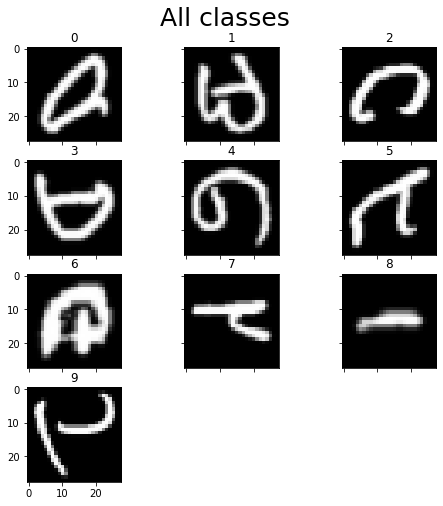

In [ ]:
visualize(range(0,10), train_data, train_targets)

Now let's focus on different samples from a same class to have an idea of the intraclass diversity. Some samples are easily recognizible, but some others are hard to distinguish for the human eye. Notice also that some letters are rotated and flipped.

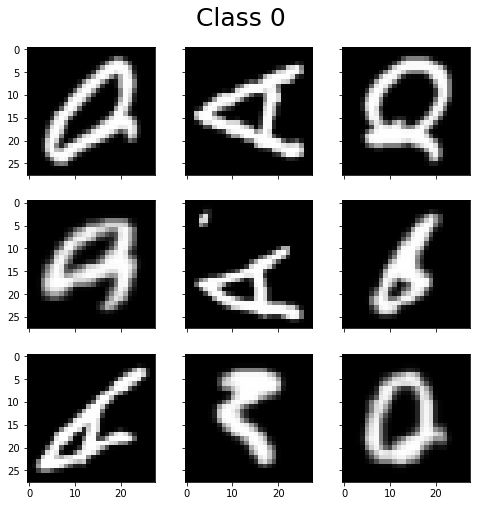

In [ ]:
visualize_single_label(0, train_data, train_targets, 9)

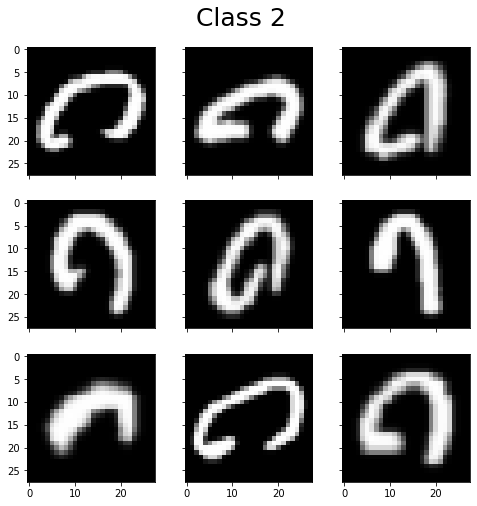

In [ ]:
visualize_single_label(2, train_data, train_targets, 9)

# Train DBN
<a id='train_dbn'></a>


A deep belief network (DBN) is a type of generative model that is composed of multiple layers of restricted Boltzmann machines (RBMs), which are a type of unsupervised deep learning algorithm. DBNs are trained by pretraining each RBM layer one at a time, and then fine-tuning the entire network using supervised learning.

Two architecture of DBN will be tried. The first one consisting of two hidden layers of 400 and 600 neurons, and the second one adding an extra hidden layer of 800 neuros. The rest of parameters such as the learning rate, the weight decay and the momentum are kept the same in order to have an easier comparison between both networks. This is also the reson why their architectures have been chosen to be nested.

In [ ]:
dbn_emnist_1 = DBN(visible_units=28*28,
                hidden_units=[400, 600],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

dbn_emnist_2 = DBN(visible_units=28*28,
                hidden_units=[400, 600, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())


Training of both DBNs is done under the same conditions: 50 epochs and a batch size of 125.

In [ ]:
num_epochs = 50
batch_size = 125

In [ ]:
%%time
# Train the first dbn

dbn_emnist_1.train_static(
    train_data,
    train_targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4235   |0.0517   |369.5934 |7.4865   |
|20    |1.3531   |0.0467   |352.5430 |5.7540   |
|30    |1.3293   |0.0467   |344.4425 |6.0129   |
|40    |1.3278   |0.0479   |345.5042 |6.2774   |
|50    |1.3146   |0.0456   |339.7595 |6.0910   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7895   |0.0470   |279.4219 |4.2964   |
|20    |1.7313   |0.0473   |275.4463 |4.4643   |
|30    |1.7242   |0.0463   |276.3459 |4.3636   |
|40    |1.7126   |0.0436   |272.4712 |4.2270   |
|50    |1.7106   |0.0491   |273.6487 |5.6051   |
CPU times: user 8min 56s, sys: 7.93 s, total: 9min 4s
Wall time: 9min 5s


In [ ]:
%%time
# Train the second dbn

dbn_emnist_2.train_static(
    train_data,
    train_targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4192   |0.0496   |369.9400 |6.1159   |
|20    |1.3510   |0.0467   |352.0622 |5.8150   |
|30    |1.3277   |0.0460   |343.7371 |6.1839   |
|40    |1.3219   |0.0455   |342.2834 |5.7581   |
|50    |1.3176   |0.0461   |341.4049 |6.2869   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8039   |0.0464   |284.1269 |4.0422   |
|20    |1.7474   |0.0440   |277.5451 |4.1211   |
|30    |1.7295   |0.0447   |274.1645 |4.2577   |
|40    |1.7282   |0.0469   |277.0278 |4.8040   |
|50    |1.7203   |0.0446   |273.6597 |4.7681   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0506   |0.0294   |349.6778 |7.5030   |
|20    |0.9869   |0.0273   |332.2113 |5.6744   |
|30    |0.9777   |0.0282   |329.3411 |5.7775   |
|40    |0.9730   |0.0275   |328.9563 |6.5885   |
|50    |0.9737

The more complex architecture takes around 80% more time for training (with CPU). Later in this work we will see if the accuracy of the more complex dbn justifies its longer training time. 

## Visualize receptive fields
<a id='receptive_fields'></a>


The receptive field of a neuron in a DBN refers to the area of the input space that the neuron is sensitive to. In other words, it's the region of the input that the neuron is capable of "seeing" or "responding to".

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

First layer internal representation for DBN(400,600)


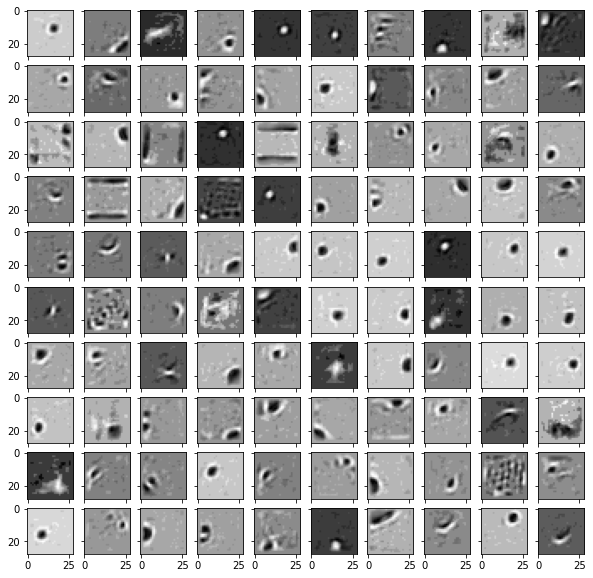

In [ ]:
# Architecture DBN(400,600) - First layer internal representation
learned_weights_layer_1_1 = get_weights(dbn_emnist_1, layer=0)
learned_weights_layer_1_1 = apply_threshold(learned_weights_layer_1_1, .1)
learned_weights_layer_1_1 = apply_min_max_scaler(learned_weights_layer_1_1)

print("First layer internal representation for DBN(400,600)")
plot_layer_receptive_fields(learned_weights_layer_1_1.T)


First layer internal representation for DBN(400,600,800)


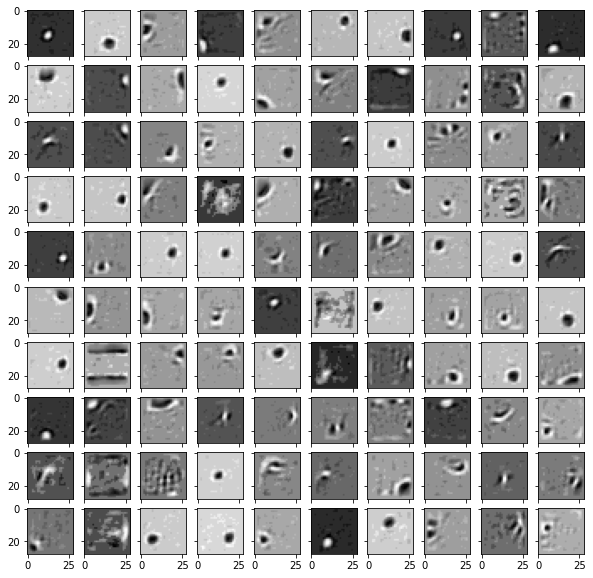

In [ ]:
# Architecture DBN(400,600,800) - First layer internal representation
learned_weights_layer_1_2 = get_weights(dbn_emnist_2, layer=0)
learned_weights_layer_1_2 = apply_threshold(learned_weights_layer_1_2, .1)
learned_weights_layer_1_2 = apply_min_max_scaler(learned_weights_layer_1_2)

print("First layer internal representation for DBN(400,600,800)")
plot_layer_receptive_fields(learned_weights_layer_1_2.T)

Second layer internal representation for DBN(400,600)


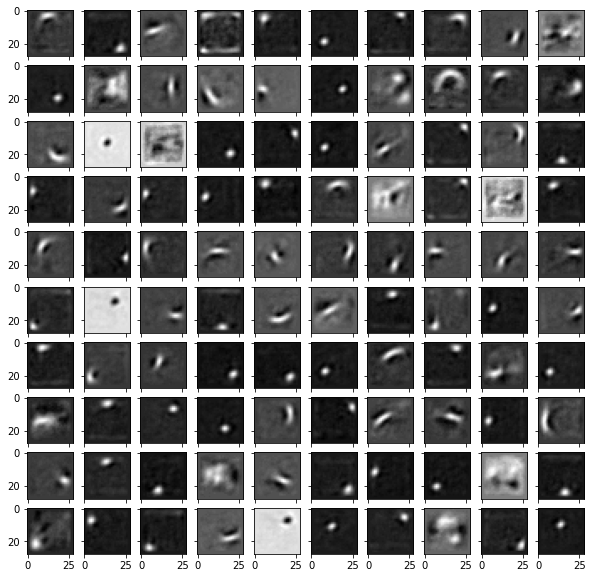

In [ ]:
# Architecture DBN(400,600) - Second layer internal representation
learned_weights_layer_1_1 = get_weights(dbn_emnist_1, layer=0)
learned_weights_layer_2_1 = get_weights(dbn_emnist_1, layer=1)

learned_weights_layer_1_1 = apply_threshold(learned_weights_layer_1_1, 0.1)
learned_weights_layer_2_1 = apply_threshold(learned_weights_layer_2_1, 0.1)

learned_weights_product_1 = (learned_weights_layer_1_1 @ learned_weights_layer_2_1)  # here we do the projection
learned_weights_product_1 = apply_threshold(learned_weights_product_1, 0.1)
learned_weights_product_1 = apply_min_max_scaler(learned_weights_product_1)


print("Second layer internal representation for DBN(400,600)")
plot_layer_receptive_fields(learned_weights_product_1.T)

Second layer internal representation for DBN(400,600,800)


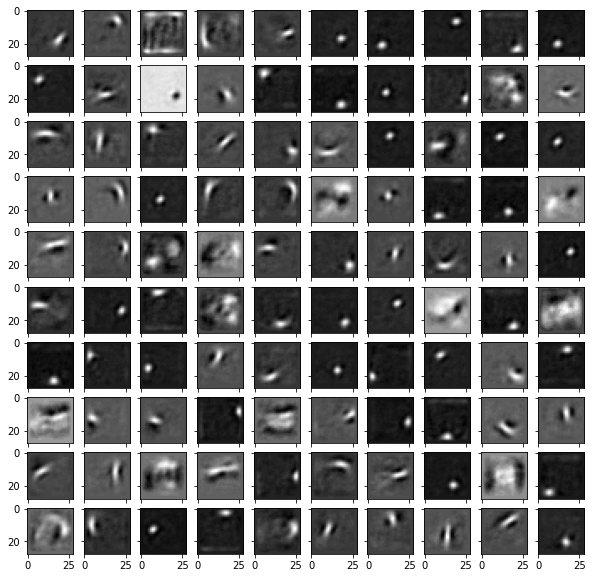

In [ ]:
# Architecture DBN(400,600,800) - Second layer internal representation
learned_weights_layer_1_2 = get_weights(dbn_emnist_2, layer=0)
learned_weights_layer_2_2 = get_weights(dbn_emnist_2, layer=1)

learned_weights_layer_1_2 = apply_threshold(learned_weights_layer_1_2, 0.1)
learned_weights_layer_2_2 = apply_threshold(learned_weights_layer_2_2, 0.1)

learned_weights_product_2 = (learned_weights_layer_1_2 @ learned_weights_layer_2_2)  # here we do the projection
learned_weights_product_2 = apply_threshold(learned_weights_product_2, 0.1)
learned_weights_product_2 = apply_min_max_scaler(learned_weights_product_2)

print("Second layer internal representation for DBN(400,600,800)")
plot_layer_receptive_fields(learned_weights_product_2.T)

Third layer internal representation for DBN(400,600,800)


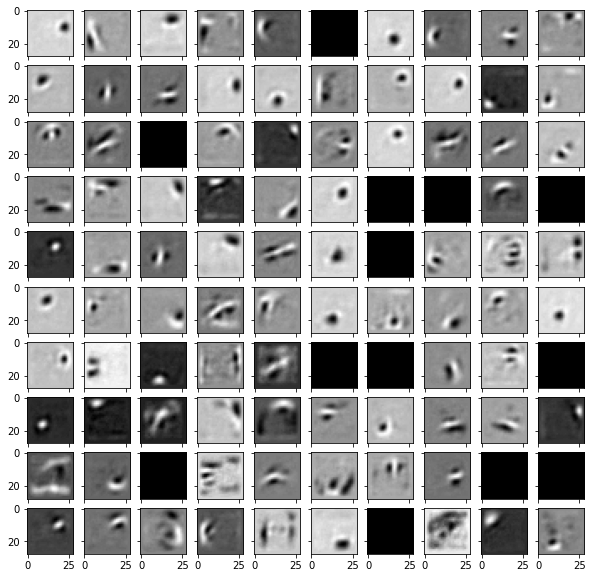

In [ ]:
# Architecture DBN(400,600,800) - Third layer internal representation
learned_weights_layer_1_2 = get_weights(dbn_emnist_2, layer=0)
learned_weights_layer_2_2 = get_weights(dbn_emnist_2, layer=1)
learned_weights_layer_3_2 = get_weights(dbn_emnist_2, layer=2)

learned_weights_layer_1_2 = apply_threshold(learned_weights_layer_1_2, 0.1)
learned_weights_layer_2_2 = apply_threshold(learned_weights_layer_2_2, 0.1)
learned_weights_layer_3_2 = apply_threshold(learned_weights_layer_3_2, 0.1)

learned_weights_12_product_2 = (learned_weights_layer_1_2 @ learned_weights_layer_2_2)  # here we do the projection
learned_weights_23_product_2 = (learned_weights_12_product_2 @ learned_weights_layer_3_2)  # here we do the projection
learned_weights_23_product_2 = apply_threshold(learned_weights_23_product_2, 0.1)
learned_weights_23_product_2 = apply_min_max_scaler(learned_weights_23_product_2)

print("Third layer internal representation for DBN(400,600,800)")
plot_layer_receptive_fields(learned_weights_23_product_2.T)

As we can see, the receptive fields of the neurons in the lower layers are larger than the receptive fields of the neurons in the higher layers. This is because the lower layers are responsible for capturing the lower-level features of the input, such as edges or small patterns, while the higher layers are responsible for capturing the higher-level features of the input, such as shapes or objects.

It's hard to tell differences between the layers of the two DBNs, but it's possible to observe how the representations in the third layer of the DBN(400,600,800) are more complex than for the rest of the layers in both models. 

## Get hidden representations

In [ ]:
def get_kth_layer_repr(model, input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = model.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
# Architecture DBN(400,600)
hidden_repr_layer_1_1 = get_kth_layer_repr(dbn_emnist_1, train_data, 0, device)
hidden_repr_layer_2_1 = get_kth_layer_repr(dbn_emnist_1, hidden_repr_layer_1_1, 1, device)

# Architecture DBN(400,600,800)
hidden_repr_layer_1_2 = get_kth_layer_repr(dbn_emnist_2, train_data, 0, device)
hidden_repr_layer_2_2 = get_kth_layer_repr(dbn_emnist_2, hidden_repr_layer_1_2, 1, device)
hidden_repr_layer_3_2 = get_kth_layer_repr(dbn_emnist_2, hidden_repr_layer_2_2, 2, device)

## Linear readout
<a id='linear_readout'></a>

In a DBN, a linear readout is a method of using the internal representations learned by the network to perform a supervised learning task.

Linear readout can be used to calculate the accuracy for each layer of the DBN. This is done by training a linear classifier on the internal representations learned by each layer of the DBN, and then evaluating the performance of the classifier on a test set. The accuracy for each layer can be calculated by comparing the predictions of the classifier with the true labels of the test set.

This allows to identify which layers of the DBN contain the most informative features for the task at hand, and can be used to understand how the network is processing the data. Furthermore, it can be used to identify which layers of the DBN are more important for the task at hand, and can be used to fine-tune the network for improved performance.


In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, n_classes)

  def forward(self, x):
    return self.linear(x)

In [ ]:
# Architecture DBN(400,600)
layer_size = dbn_emnist_1.rbm_layers[0].W.shape[1]
linear1_1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist_1.rbm_layers[1].W.shape[1]
linear2_1 = LinearModel(layer_size).to(device)

# Architecture DBN(400,600,800)
layer_size = dbn_emnist_2.rbm_layers[0].W.shape[1]
linear1_2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist_2.rbm_layers[1].W.shape[1]
linear2_2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist_2.rbm_layers[2].W.shape[1]
linear3_2 = LinearModel(layer_size).to(device)

In [ ]:
def train_linear(network, input, epochs=1000, verbose = False):
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets = train_targets

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0 and verbose == True:
      print("epoch: {:4d}/{} | loss: {:.3f}".format(epoch, epochs, loss))

In [ ]:
# Architecture DBN(400,600)
train_linear(linear1_1, hidden_repr_layer_1_1, epochs = 1500)
train_linear(linear2_1, hidden_repr_layer_2_1, epochs = 1500)

# Architecture DBN(400,600,800)
train_linear(linear1_2, hidden_repr_layer_1_2, epochs = 1500)
train_linear(linear2_2, hidden_repr_layer_2_2, epochs = 1500)
train_linear(linear3_2, hidden_repr_layer_3_2, epochs = 1500)

In [ ]:
# Architecture DBN(400,600)
hidden_repr_layer_1_test_1 = get_kth_layer_repr(dbn_emnist_1, test_data, 0, device)
hidden_repr_layer_2_test_1 = get_kth_layer_repr(dbn_emnist_1, hidden_repr_layer_1_test_1, 1, device)

# Architecture DBN(400,600,800)
hidden_repr_layer_1_test_2 = get_kth_layer_repr(dbn_emnist_2, test_data, 0, device)
hidden_repr_layer_2_test_2 = get_kth_layer_repr(dbn_emnist_2, hidden_repr_layer_1_test_2, 1, device)
hidden_repr_layer_3_test_2 = get_kth_layer_repr(dbn_emnist_2, hidden_repr_layer_2_test_2, 2, device)

Here we compute the predictions

In [ ]:
# Architecture DBN(400,600)
predictions_test1_1 = linear1_1(hidden_repr_layer_1_test_1)
predictions_test2_1 = linear2_1(hidden_repr_layer_2_test_1)


# Architecture DBN(400,600,800)
predictions_test1_2 = linear1_2(hidden_repr_layer_1_test_2)
predictions_test2_2 = linear2_2(hidden_repr_layer_2_test_2)
predictions_test3_2 = linear3_2(hidden_repr_layer_3_test_2)

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
print(f"First layer accuracy simpler model: {compute_accuracy(predictions_test1_1, test_targets)}")
print(f"Second layer accuracy simpler model: {compute_accuracy(predictions_test2_1, test_targets)} \n")


print(f"First layer accuracy complex model: {compute_accuracy(predictions_test1_2, test_targets)}")
print(f"Second layer accuracy complex model: {compute_accuracy(predictions_test2_2, test_targets)}")
print(f"Third layer accuracy complex model: {compute_accuracy(predictions_test3_2, test_targets)}")

First layer accuracy simpler model: 0.8511250019073486
Second layer accuracy simpler model: 0.8607500195503235 

First layer accuracy complex model: 0.8508750200271606
Second layer accuracy complex model: 0.8600000143051147
Third layer accuracy complex model: 0.8692499995231628


The first, more simple model, is performing better than the more complex one, in both the first and second layers. Taking into account that this model is also much faster to train, we will keep it for future analysis and discard the more complex model.

## Clustering internal representations
<a id='clustering_representations'></a>

In DBNs, clustering internal representations refers to the process of grouping similar representations of the input data together by training the DBN to learn a compact and meaningful representation of the data in the internal layers. The clustering is performed on the internal representations of the data that are learned by the DBN's unsupervised pre-training phase.

The goal of clustering the internal representations is to group similar data points together in a way that captures the underlying structure of the data.

There are several ways to perform clustering on the internal representations of a DBN. One popular method is to use k-means clustering algorithm to group similar representations together. Another approach, used here, is to use hierarchical clustering algorithm, which can capture the hierarchical structure of the data, and allows to explore different levels of granularity.






In [ ]:
def get_mask(label, tr_targets):  # we use this function to filter by class
  return tr_targets.cpu().numpy() == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label, train_targets)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(n_classes)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(n_classes)])


def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  letter_labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete") 
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=letter_labels)
  ax.set_title(title)


In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2_1)

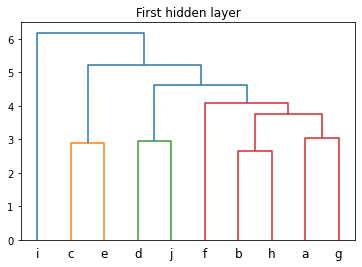

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer") 

At the first hidden layer the DBM is considering the previous subclusters of letters as having visually similar representations. For example ***a*** and ***g*** or ***c*** and ***e***.

If I was asked how I would cluster these letters according to their visual representation I would have probably agreed with this result or come up with a similar one, and I think many other people would have too. Of course, we need to bear in mind that we have both lower case and capital letters and this makes the task of finding similar representations very hard. As we know, some letters have very different representation in their lower case and capital letter. Such is the case of A, E, G and H. Considering  this I would jusdge the result is good. But let's check what the next layer has done.

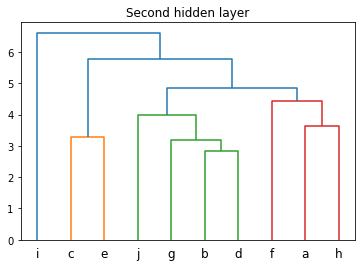

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer") 

For this second hidden layer there are some variations in the clusters. For example ***b*** and ***d*** are now in the same subcluster, which makes sense since they are really similar in their lowercase representation. Regarding ***a*** and ***h*** they are not the most similar ones, but have some similarity in their lower case vaersion and also their capital version, so it makes sense that the model puts them in the same subcluster.

# Comparison to a FFNN
<a id='fnn'></a>

A feedforward neural network (FFNN) is a type of supervised deep learning algorithm that is composed of multiple layers of artificial neurons. FFNNs are trained by backpropagating the error between the network's output and the target output through the layers of the network.

Both DBNs and FFNNs have their own advantages and disadvantages. DBNs are good at learning the underlying structure of the data, and can be used for unsupervised feature learning or generative modeling. FFNNs, on the other hand, are good at learning to make predictions based on labeled data, and can be used for supervised learning tasks like classification or regression.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.output = torch.nn.Linear(second_hidden_layer_size, n_classes)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    output = self.output(second_hidden_repr)
    return output

Let's now train a Feed Forward Neural Network (FFNN) for comparison. We'll keep the same architecture as for the DBN to make the comparison as fair as possible.

In [ ]:
ffnn = Feedforward(400, 600).to(device)

In [ ]:
%%time
train_linear(ffnn, train_data.reshape((train_data.shape[0], 784)), epochs=1500)

CPU times: user 53min 25s, sys: 29.1 s, total: 53min 54s
Wall time: 53min 46s


In [ ]:
predictions_ffnn = ffnn(test_data.reshape((test_data.shape[0], 784)))
compute_accuracy(predictions_ffnn, test_targets)

0.8820000290870667

We can observe two things here. First that the training time is much lower for the DBN than for the FFNN (9:02 compared to 53:46 minutes). Second, the accuracy of the FFNN is slightly higher than for the DBN. I consider the DBN is better in this case. It's more convenient to have a much fater training at the expense of a minimum decrease in accuracy. But to better substantiate this conclusion, let's compare both networks' performance against noisy data and adversarial attacks.

# Robustness to noise
<a id='noise'></a>

In this section let's try the robustness of the DBN and the FFNN to noise. 

First let's define a function to inject both random gaussian noise and salt & pepper noise to the test data.

In [ ]:
def inject_noise(data, noise_level):
  return data + noise_level * torch.randn(data.shape, device = device)

def inject_saltpepper_noise(data, noise_level):
  return torch.tensor(random_noise(data.cpu(), mode='s&p', amount = noise_level))

Let's now inject some noise to our EMNIST-"letter" test set and visualize some examples of images with each type of noise.

In [ ]:
noise_level = 0.3
emnist_test_random_noise = inject_noise(test_data, noise_level)
emnist_test_saltpepper_noise = inject_saltpepper_noise(test_data, noise_level)

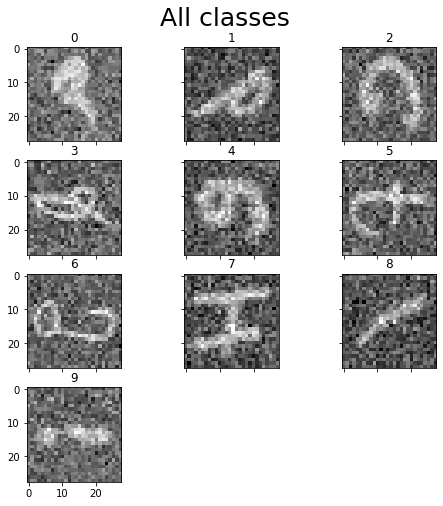

In [ ]:
# print("With random gaussian noise:")
visualize(range(0,10), emnist_test_random_noise, test_targets)

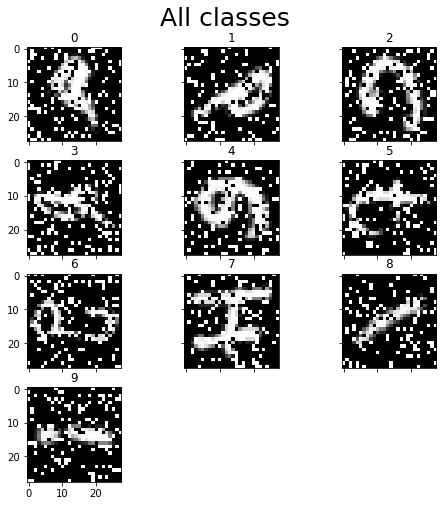

In [ ]:
# print("With salt and pepper noise:")
visualize(range(0,10), emnist_test_saltpepper_noise, test_targets)

In both cases the noise is quite invasive, in the sense that to the human eye is quite hard to understand that it's the letter a what is being represented. Let's see how both the DBN and the FFNN behave when the noise is present.

In [ ]:
def get_accuracy_values_at_noise_level(noise_generator, noise_level, test_dt, test_tgts):

  emnist_test_with_noise = noise_generator(test_dt, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(dbn_emnist_1, emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(dbn_emnist_1, hidden_repr_layer_1_noisy, 1, device)
  
  predictions_first_hidden_noisy = linear1_1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2_1(hidden_repr_layer_2_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_tgts)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_tgts)
  
  # Similarly for the FFNN:

  predictions_ffnn = ffnn(emnist_test_with_noise.reshape((test_dt.shape[0], 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn, test_tgts)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_ffnn

In [ ]:
acc_random = get_accuracy_values_at_noise_level(inject_noise, 0.3, test_data, test_targets)
acc_saltpepper = get_accuracy_values_at_noise_level(inject_saltpepper_noise, 0.3, test_data, test_targets)

# Random noise
print("Random noise: ")
print("Accuracy of H1 read-out: %.3f" % acc_random[0])
print("Accuracy of H2 read-out: %.3f" % acc_random[1])
print("Accuracy of FF network : %.3f" % acc_random[2])

# Salt pepper noise
print("Salt and pepper noise: ")
print("Accuracy of H1 read-out: %.3f" % acc_saltpepper[0])
print("Accuracy of H2 read-out: %.3f" % acc_saltpepper[1])
print("Accuracy of FF network : %.3f" % acc_saltpepper[2])

Random noise: 
Accuracy of H1 read-out: 0.825
Accuracy of H2 read-out: 0.852
Accuracy of FF network : 0.850
Salt and pepper noise: 
Accuracy of H1 read-out: 0.500
Accuracy of H2 read-out: 0.601
Accuracy of FF network : 0.527


In general the accuracy when the noise is present is quite good and slightly worse than for the case without any noise. Still, the FNN performs the best for this level of noise, but let's check if this is the case for different noise levels.

## Effect of the strength parameter $\epsilon$

In [ ]:
def plot_noise_robustness_curves(noise_generator, noise_levels, test_data, test_targets):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_generator, noise_level, test_data, test_targets)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_ffnn.append(acc[2])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "FFNN"])

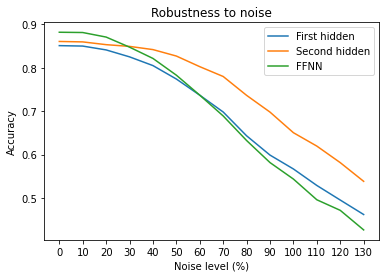

In [ ]:
# Plot robustness to random gaussian noise
noise_levels = np.arange(0,1.4,0.1).tolist()
plot_noise_robustness_curves(inject_noise, noise_levels, test_data, test_targets)

The FFNN is clearly more robust to noises up to 35%. From that point the second hidden layer of the DBN is much more robust than the FFNN. We also see that around 65% even the first hidden layer of the DBN outperforms the FFNN. 



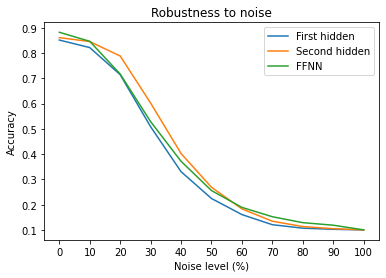

In [ ]:
# Plot robustness to salt and pepper noise
noise_levels = np.arange(0,1.1,0.1).tolist()
plot_noise_robustness_curves(inject_saltpepper_noise, noise_levels, test_data, test_targets)

In the case of salt and pepper noise, the second layer of the DBN is the best from almost the beginning until around 65% of noise lever. From here, FFNN performs better, but they tend to the same value towards 100% noise level. The first layer of the DBN is always the worst performing one. 

We can conclude that DBN is more robust to noise than FFNN. This corroborates what learned in class. DBN are generally more robust to noise because:

1. The unsupervised pre-training step allows DBNs to learn useful features from the data.

2. DBNs are particularly good at learning internal representations of the data, which can help to make the network more robust to noise. By extracting more robust and relevant features from the data, DBNs can produce better predictions even when the data is noisy.

3. Greedy layer-wise training: DBNs are trained layer-wise, where each layer is trained independently before moving on to the next one.

Of course, robustness also depends on architecture and training parameters, not only on the type of neural network. 

# Adversarial attacks
<a id='adversarial_attacks'></a>

Adversarial attacks refer to methods of deliberately introducing small, strategically-crafted perturbations to the input of a neural network in order to cause the network to produce incorrect or undesirable output. These perturbations are often imperceptible to humans, yet can cause a neural network to make a wrong prediction or classification. 

In this part, we will attack images and test how the neural networks respond to them. The attacks are not targeted, we only aim to cause the neural network to produce any incorrect label, no matter what label this is.

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])


In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist_1, [linear1_1, linear2_1], readout_level=1)

Let's see first an example of an image without having performed the attack. Later we will attack it and compare.

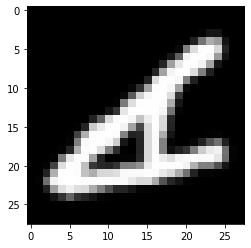

In [ ]:
test_sample_idx = 1
test_image = test_data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = 'gray')

In [ ]:
def attack(attacked_model):

  # First check what the model predicts without having performed the attack
  test_image.requires_grad_()
  model_outputs = attacked_model(test_image)
  prediction = torch.argmax(model_outputs)
  print(f"The prediction of the model for this clean sample is {prediction}.")

  # Attack
  epsilon = 0.2  # define strenght of the attack
  test_image_label = test_targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
  loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
  attacked_model.zero_grad()
  loss_value.backward()
  image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
  perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

  perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
  __ = plt.imshow(perturbed_image_np.reshape(28,28), cmap = 'gray')


  # See what label the model predicts now
  model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
  print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for this clean sample is 0.
The prediction of the model for the perturbed sample is 7.


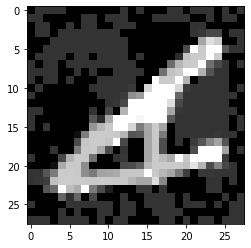

In [ ]:
# Attack ffnn
attack(attacked_model = ffnn)

The prediction of the model for this clean sample is 0.
The prediction of the model for the perturbed sample is 7.


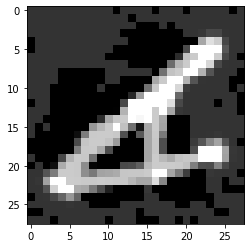

In [ ]:
# Attack dbn
attack(attacked_model = dbn_with_readout)

The attack is successful in both cases because the model is incorreclty predicting the class of the image in question. This is for a strenght of the attack of 0.2. We'll test later what happens to different attack strenghths. 

## Robustness to adversarial attacks

In this subsection we'll see how both the DBN and the FFNN resist adversarial attacks on the test images.


In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, do not attack, just continue
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
            print("\nHere's the original sample:\n")
            plt.imshow(data.detach().cpu().numpy().reshape(28,28))
            plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().cpu().numpy().reshape(28,28))
            plt.show()
        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):                
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().cpu().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
        print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [ ]:
data = [[d, l] for d, l in zip(test_data, test_targets)]

test_loader = torch.utils.data.DataLoader(
    data,
    shuffle = True,
    batch_size = 1
)


Let's see how good the FFNN does:

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 8000/8000 [00:14<00:00, 538.91it/s]


Epsilon: 0.1	Test Accuracy = 1991 / 8000 = 0.248875



Out of 8000 attacked test images, 1991 have been correctly classified despite the attack. That's an accuracy of only 24.9%. The strength of the attack that was used is 0.1.

Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

100%|██████████| 8000/8000 [00:18<00:00, 443.18it/s]


Epsilon: 0.1	Test Accuracy = 5157 / 8000 = 0.644625



The DBN performs much better than the FFNN, getting an accuracy of 64.4%. This is of c

Finally let's test if by using one step of top-down reconstruction from the generative model we can improve the resilience to attacks of the DBN.

  0%|          | 0/8000 [00:00<?, ?it/s]


Here's the original sample:



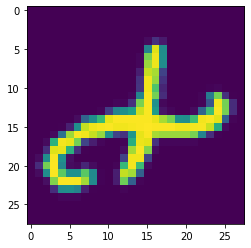


Here's a perturbed sample:



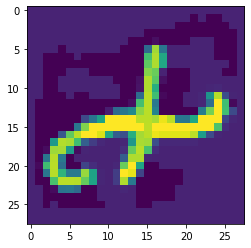


Here's what a 1-steps reconstructed sample looks like:



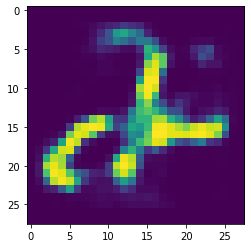

100%|██████████| 8000/8000 [00:26<00:00, 300.85it/s]


Epsilon: 0.1	Test Accuracy = 5250 / 8000 = 0.65625



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

The ability of the DBN to reduce the impact of the attacks was slightly improved by using reconstruction from the generative model. Even though it's not a big relative improvement (around 100/8000 more images) it's a useful property that DBN have and differentiate them from FFNN. The fact that DBN are trained in an unsupervised setting and can learn robust representations of the data make them a useful tool against adversarial attacks.

### Effect of the strength parameter $\epsilon$

In this last subsection we'll compare the robustness of each model to adversarial attacks of different "strengths". For that we'll give epsilon different values ranging from 0 to 0.3.

In [ ]:
epsilon_values = np.arange(0,0.3,0.05).tolist()

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

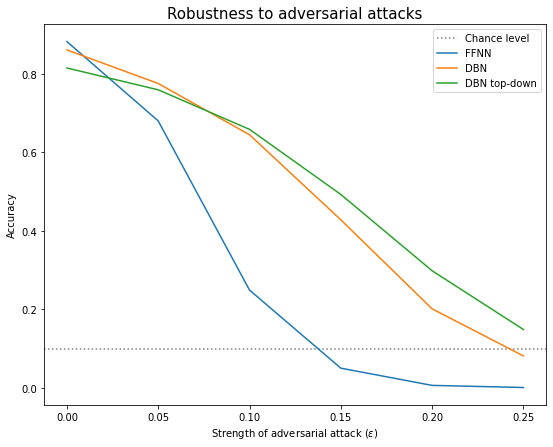

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

FFNN has clearly the worst performance. It is the same as chance for epsilons greater than 0.14. On the other hand, DBN resists well until epsilon values of around 0.25. DBN with top-down reconstruction shows the best performance for a long range of values. 